<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#One-Dimensional-Climate-Models:-The-Basics" data-toc-modified-id="One-Dimensional-Climate-Models:-The-Basics-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>One-Dimensional Climate Models: The Basics</a></span><ul class="toc-item"><li><span><a href="#What-does-a-climate-model-solve-for?" data-toc-modified-id="What-does-a-climate-model-solve-for?-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>What does a climate model solve for?</a></span></li><li><span><a href="#Starting-up-the-Run" data-toc-modified-id="Starting-up-the-Run-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Starting up the Run</a></span></li><li><span><a href="#Initial-T(P)-Guess" data-toc-modified-id="Initial-T(P)-Guess-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Initial T(P) Guess</a></span></li></ul></li></ul></div>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import picaso.justdoit as jdi
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# One-Dimensional Climate Models: The Basics

In this tutorial you will learn the very basics of running 1D climate runs. For a more in depth look at the climate code check out [Mukherjee et al. 2022](https://arxiv.org/abs/2208.07836) (note this should also be cited if using this code/tutorial). 

What you should already be familiar with: 

- [basics of running/analyzing thermal spectra](https://natashabatalha.github.io/picaso/tutorials.html#basics-of-thermal-emission)
- [how to analyze thermal emission spectra](https://natashabatalha.github.io/picaso/notebooks/workshops/ERS2021/ThermalEmissionTutorial.html)

What you will need to download to use this tutorial: 

1. [Download](https://zenodo.org/record/6708165#.YwPuGOzMI-Q) 196 Correlated-K Tables from Roxana Lupu to be used by the climate code for opacity 
2. [Download](https://zenodo.org/record/5063476/files/structures_m%2B0.0.tar.gz?download=1) the sonora bobcat cloud free `structures_` file so that you can validate your model run 

**Note**: the two files above are dependent on metallicity and C/O. For this tutorial we will stick to solar M/H and solar C/O, but note that you can change that in the future. 

In [69]:
#1 ck tables from roxana
mh = '+000'#'+0.0' #log metallicity
CtoO = '100'#'1.0' # CtoO ratio

ck_db = f'/Users/nbatalh1/Documents/data/kcoeff_2020/sonora_2020_feh{mh}_co_{CtoO}.data.196'

#sonora bobcat cloud free structures file
sonora_profile_db = '/Users/nbatalh1/Documents/data/sonora_bobcat/structures_m+0.0/'

## What does a climate model solve for?

1D Radiative-Convective Equilibrium Models solve for atmospheric structures of brown dwarfs and exoplanets, which includes:

1\. The Temperature Structure (T(P) profile)
 
2\. The Chemical Structure 

3\. Energy Transport in the atmosphere

4\. Clouds 

But these physical components are not independent of each other. For example, the chemistry is dependent on the T(P) profile, the radiative transfer is dependent on clouds and the chemistry and so on. 

`PICASO` tries to find the atmospheric state of your object by taking care of all of these processes and their interconnections self-consistently and iteratively. Therefore, you will find that the climate portion of `PICASO` is slower than running a single forward model evaluation. 

## Starting up the Run

You will notice that starting a run is nearly identical as running a spectrum. However, how we will add `climate=True` to our inputs flag. We will also specify `browndwarf` in this case, which will turn off the irradiation the object is receiving. 

New Parameter: **Effective Temperature**. This excerpt from [Modeling Exoplanetary Atmospheres (Fortney et al)](https://arxiv.org/pdf/1804.08149.pdf) provides a thorough description and more reading, if you are interested.

> If the effective temperature, $T_{eff}$, is defined as the temperature of a blackbody of
the same radius that would emit the equivalent flux as the real planet, $T_{eff}$ and $T_{eq}$
can be simply related. This relation requires the inclusion of a third temperature,
$T_{int}$, the intrinsic effective temperature, that describes the flux from the planet’s
interior. These temperatures are related by:
$$T_{eff} =  T_{int} + T_{eq}$$
> We then recover our limiting cases: if a planet is self-luminous (like a young giant
planet) and far from its parent star, $T_{eff} \approx  T_{int}$; for most rocky planets, or any
planets under extreme stellar irradiation, $T_{eff} \approx T_{eq}$.

In [73]:
import importlib;importlib.reload(jdi)

<module 'picaso.justdoit' from '/Users/nbatalh1/Documents/codes/PICASO/picaso/picaso/justdoit.py'>

In [74]:
cl_run = jdi.inputs(calculation="browndwarf", climate = True) # start a calculation 

#note you need to put the climate keyword to be True in order to do so
# now you need to add these parameters to your calculation  


teff= 1000 # Effective Temperature of your Brown Dwarf in K
grav = 1000 # Gravity of your brown dwarf in m/s/s

cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run.effective_temp(teff) # input effective temperature

Let's now grab our gaseous opacities, whose path we have already defined above. Again, this code uses a correlated-k approach for accurately capturing opacities (see [section 2.1.4; Mukerjee et al 2022](https://arxiv.org/pdf/2208.07836.pdf)).

In [75]:
# Notice The keyword ck is set to True because you want to use the correlated-k opacities for your calculation
# and not the line by line opacities
opacity_ck = jdi.opannection(ck_db=ck_db) # grab your opacities

## Initial T(P) Guess 

Every calculation requires an initial guess of the pressure temperature profile. The code will iterate from there to find the correct solution. A few tips: 

1. We recommend **using typically 51-91 atmospheric pressure levels**. Too many pressure layers increases the computational time required for convergence. Too little layers makes the atmospheric grid too coarse for an accurate calculation.

2. Start with **a guess that is close to your expected solution**. We will show an example using an isothermal P(T) profile below so you can see the iterative process. Later though, we recommend leveraging pre-computed grids (e.g. Sonora) as a starting guess. 


In [6]:
nlevel = 91 # number of plane-parallel levels in your code

#Lets set the max and min at 1e-4 bars and 500 bars

Pmin = 1e-4 #bars
Pmax = 500 #bars
pressure=np.logspace(np.log10(Pmin),np.log10(Pmax),nlevel) # set your pressure grid

temp_guess = np.zeros(shape=(nlevel)) + 500 # K , isothermal atmosphere guess

You also need to have a crude guess of the convective zone of your atmosphere. Generally the deeper atmosphere is always convective. Again a good guess is always the published SONORA grid of models for this. But lets assume that the bottom 7 levels of the atmosphere is convective. 

In [8]:

    
nofczns = 1 # number of convective zones initially, don't change this 

nstr_upper = 83 # top most level of guessed convective zone
nstr_deep = nlevel -2 # this is always the case. Dont change this
nstr = np.array([0,nstr_upper,nstr_deep,0,0,0]) # initial guess of convective zones

# Here are some other parameters needed for the code.
rfacv = 0.0 # This is for stellar incident radiation. This is zero for brown dwarfs as we are not concerned with stellar radiation.
rfaci =1.0 # This is 1 always.
cloudy = False # not cloudy
fsed = 0.0 # as not cloudy so won't matter

    

Now we would use the inputs_climate function to input everything together to our cl_run we started.

In [9]:
cl_run.inputs_climate(temp_guess= temp_guess, pressure= pressure, 
                      nstr = nstr, nofczns = nofczns , rfacv = rfacv, 
                      rfaci = rfaci, cloudy = cloudy, mh = mh, 
                      CtoO = CtoO,species = ['MgSiO3','Mg2SiO4','Fe'], fsed = fsed)


 The actual climate code can be run with the cl_run.run command. The save_all_profiles is set to True to save the T(P) profile at all steps. The code will now iterate from your guess to reach the correct atmospheric solution for your brown dwarf of interest.
 Okay !!! We are all set to do our run. Let's hope for the best...
 
 

In [12]:
out = cl_run.run_climate_model(opacity_ck,
                                      save_all_profiles=True, 
                                      save_all_kzz = False,
                                      diseq_chem = False, 
                                      self_consistent_kzz =self_consistent_kzz,
                                      vulcan_run = False)

Iteration number  0 , min , max temp  344.63951911492535 3465.457575188653 , flux balance  -5.111487201726878e-08
Converged Solution in iterations  0
Big iteration is  344.63951911492535 0
 We are already at a root, tolf , test =  5e-05 ,  2.57626281600421e-05
Profile converged
 We are already at a root, tolf , test =  5e-05 ,  2.57626281600421e-05
Big iteration is  344.63951911492535 0
 We are already at a root, tolf , test =  5e-05 ,  2.57626281600421e-05
Profile converged
final [ 0 73 89  0  0  0]
 We are already at a root, tolf , test =  5e-05 ,  2.57626281600421e-05
Big iteration is  344.63951911492535 0
 We are already at a root, tolf , test =  5e-05 ,  2.57626281600421e-05
Profile converged
YAY ! ENDING WITH CONVERGENCE


In [13]:
pressure , temp, dtdp, nstr_new, flux_plus_final, df, all_profiles,opd_now,w0_now,g0_now = out

 Let's see how our run tallies with the SONORA bobcat published models

Text(0.5, 1.0, 'T$_{\\rm eff}$= 1000 K, log(g)=5.0')

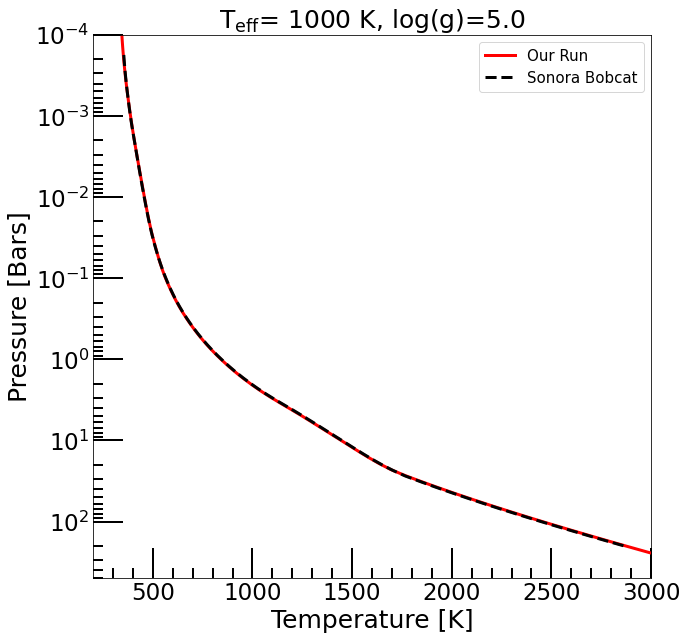

In [14]:
pressure_bobcat,temp_bobcat = np.loadtxt("/Users/nbatalh1/Documents/data/sonora_bobcat/structures_m+0.0/t"+str(1000)+"g1000"+"nc_m0.0.dat",
                                         usecols=[1,2],unpack=True, skiprows = 1)

plt.figure(figsize=(10,10))
plt.ylabel("Pressure [Bars]", fontsize=25)
plt.xlabel('Temperature [K]', fontsize=25)
plt.ylim(500,1e-4)
plt.xlim(200,3000)

plt.semilogy(temp,pressure,color="r",linewidth=3,label="Our Run")

plt.semilogy(temp_bobcat,pressure_bobcat,color="k",linestyle="--",linewidth=3,label="Sonora Bobcat")


plt.minorticks_on()
plt.tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=23)
plt.tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)

plt.legend(fontsize=15)

plt.title(r"T$_{\rm eff}$= 1000 K, log(g)=5.0",fontsize=25)



We can also try to see how our initial guess of an isothermal atmosphere was changed by the code to reach the converged solution

In [15]:
# lets copy our outputs first to new arrays so that we accidentally don't change anything while 
# doing our animation on the original outputs otherwise will have to rerun the time consuming code again

t_eq,p_eq,df_eq,all_profiles_eq = np.copy(temp), np.copy(pressure), df,np.copy(all_profiles)

In [65]:
importlib.reload(jdi)

<module 'picaso.justdoit' from '/Users/nbatalh1/Documents/codes/PICASO/picaso/picaso/justdoit.py'>

In [66]:
co,h2o,nh3,ch4 = np.zeros(len(all_profiles_eq)),np.zeros(len(all_profiles_eq)),np.zeros(len(all_profiles_eq)),np.zeros(len(all_profiles_eq))
spec = np.zeros(shape =(int(len(all_profiles_eq)/91),196))
for i in range(int(len(all_profiles_eq)/91)):
#for i in range(5):
    bd = jdi.inputs(calculation='brown')

    bd.phase_angle(0)
    bd.gravity(gravity=1000 , gravity_unit=u.Unit('m/s**2'))

    sonora_profile_db = '/Users/nbatalh1/Documents/data/sonora_bobcat/structures_m+0.0/'
    Teff_dummy = 1000
    bd.sonora(sonora_profile_db, Teff_dummy)
    
    bd.inputs['atmosphere']['profile']['pressure'] =p_eq
    bd.inputs['atmosphere']['profile']['temperature'] = all_profiles_eq[i*91:(i+1)*91]
    bd.premix_atmosphere(opacity_ck,bd.inputs['atmosphere']['profile'])
    
    df_spec = bd.spectrum(opacity_ck,full_output=True)
    spec[i,:] = df_spec['thermal']
    co[i*91:(i+1)*91] = bd.inputs['atmosphere']['profile']['CO']
    h2o[i*91:(i+1)*91] = bd.inputs['atmosphere']['profile']['H2O']
    nh3[i*91:(i+1)*91] = bd.inputs['atmosphere']['profile']['NH3']
    ch4[i*91:(i+1)*91] = bd.inputs['atmosphere']['profile']['CH4']
    #x,y = jdi.mean_regrid(1e4/df_spec['wavenumber'], df_spec['thermal'], R=500)
    
wh = np.where( (1e4/df_spec['wavenumber'] > 0.0) & (1e4/df_spec['wavenumber'] < 6))
wv = 1e4/df_spec['wavenumber'][wh]    
    



Lets run the animation code now

In [67]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

writergif = animation.PillowWriter(fps=3) 
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"


x='''
AA.BB.CC
'''
fig = plt.figure(figsize=(35,10))

ax = fig.subplot_mosaic(x,gridspec_kw={
        # set the height ratios between the rows
        "height_ratios": [1],
        # set the width ratios between the columns
        "width_ratios": [1,1,0.1,1,1,0.1,1,1]})

temp = all_profiles_eq[0*91:(0+1)*91]
line0, = ax['A'].semilogy(temp_bobcat,pressure_bobcat,color="k",linestyle="--",linewidth=3)
line, = ax['A'].semilogy(temp, p_eq,linewidth=3,color='r')
line1, = ax['B'].loglog(co[0:91], p_eq,linewidth=3,color='g',label="CO")
line2, = ax['B'].loglog(ch4[0:91], p_eq,linewidth=3,color='b',label="CH$_4$")
line3, = ax['C'].semilogy(1e4/df_spec['wavenumber'], spec[0,:],linewidth=3,color="r")
line4, = ax['B'].loglog(h2o[0:91], p_eq,linewidth=3,color='pink',label="H$_2$O")
line5, = ax['B'].loglog(nh3[0:91], p_eq,linewidth=3,color='salmon',label="NH$_3$")

def init():
    #line.set_ydata(np.ma.array(x, mask=True))
    
    ax['A'].set_xlabel('Temperature [K]',fontsize=30)
    ax['A'].set_ylabel('Pressure [Bars]',fontsize=30)
    ax['A'].set_xlim(200,2900)
    ax['A'].set_ylim(205,1.8e-4)
    ax['B'].set_xlabel('Abundance [V/V]',fontsize=30)
    ax['B'].set_ylabel('Pressure [Bars]',fontsize=30)
    ax['B'].set_xlim(1e-6,1e-2)
    ax['B'].set_ylim(205,1.8e-4)
    ax['B'].legend(fontsize=20)
    ax['C'].set_xlabel('Wavelength [$\mu$m]',fontsize=30)
    ax['C'].set_ylabel('Flux',fontsize=30)
    ax['C'].set_xlim(0,6)
    ax['C'].set_ylim(1e7,1e14)
    ax['A'].minorticks_on()
    ax['A'].tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=30)
    ax['A'].tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=30)
    ax['B'].minorticks_on()
    ax['B'].tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=30)
    ax['B'].tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=30)
    ax['C'].minorticks_on()
    ax['C'].tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=30)
    ax['C'].tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=30)
    
    line.set_ydata(p_eq)
    line1.set_ydata(p_eq)
    line2.set_ydata(p_eq)
    line3.set_xdata(wv)
    line4.set_ydata(p_eq)
    line5.set_ydata(p_eq)
    
    #time_text.set_text('')
    return line,line1,line2,line3,line4,line5#,time_text        #return the variables that will updated in each frame
    
def animate(i):                  # 'i' is the number of frames  
    line.set_xdata(all_profiles_eq[i*91:(i+1)*91])
    line1.set_xdata(co[i*91:(i+1)*91])
    line2.set_xdata(ch4[i*91:(i+1)*91])
    line3.set_ydata(spec[i,:][wh])# update the data
    line4.set_xdata(h2o[i*91:(i+1)*91])
    line5.set_xdata(nh3[i*91:(i+1)*91])
    #time_text.set_text(' frame number = %.1d' % i)  
    return line,line1,line2,line3,line4,line5

ani = animation.FuncAnimation(fig, animate, frames=int(len(all_profiles_eq)/91),init_func=init,interval=50, blit=False)
plt.close()
ani
#ani.save('Benchmarking/anim.gif', writer=writergif)

1) Was our choice of the pressure grid correct?

If your pressure grid is such that one can basically look through your atmosphere till the bottom then your grid is not correct and the converged solution are also not correct. This looking through might happen if we do not go deep enough in the atmosphere pressure grid. Then in wavelengths where gas/continuum opacities are low, one can look to the bottom of your model which is not good.


A good way to check this is by calculation of the brightness temperature of the emergent spectrum from your converged model. Brightness temperature of your thermal spectra at a certain wavelength gives you a rough measure of the temperature responsible for the flux you are seeing at that wavelength. Note that this temperature doesn't need to be the physical temperature of your atmosphere but if you can find the physical converged atmospheric temperature closest to this brightness temperature you can also get an idea of the atmospheric pressure from where the flux you are seeing is originating from.

$T_{\rm bright}=\dfrac{a}{{\lambda}log\left(\dfrac{{b}}{F(\lambda){\lambda}^5}+1\right)}$

where a = 1.43877735$\times$10$^{-2}$ m.K and b = 11.91042952$\times$10$^{-17}$ m$^4$kg/s$^3$ 

Let's calculate the brigthness temperature of our current run and check if our pressure grid was okay.

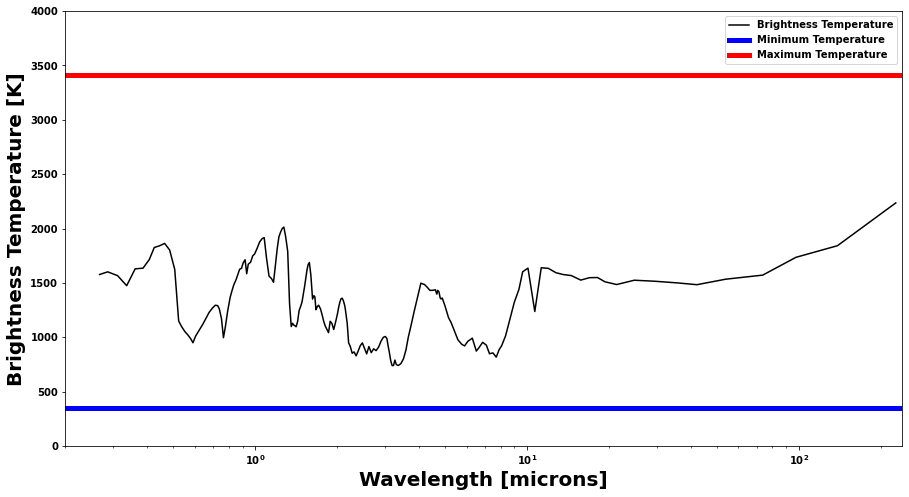

In [40]:
brightness_temp, figure= jpi.brightness_temperature(df_spec)

So our run was good and our choice of the pressure grid is also great. Well done team !

But let's check out a run which is not okay so that we are cautious while using the code. Let's do the same run by the max pressure set at only 30 bars instead of 500 bars.

In [ ]:

T_eff= 1000 # Effective Temperature of your Brown Dwarf in K
grav = 1000 # Gravity of your brown dwarf in m/s/s

cl_run_nok = jdi.inputs(calculation="brown", climate = True) # start a calculation 

#note you need to put the climate keyword to be True in order to do so
# now you need to add these parameters to your calculation  

cl_run_nok.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run_nok.T_eff(Teff=T_eff) # input effective temperature



T_star = "NA" # K, As it is a isolated brown dwarf, these params are not needed so 'NA'
semi_major = "NA" # AU,  As it is a isolated brown dwarf, these params are not needed so 'NA'
# ignore this for now
self_consistent_kzz= False # Only needed if you want to do on-the-fly calculation with MLT Kzz



nlevel = 91 # number of plane-parallel levels in your code

#Lets set the max and min at 1e-4 bars and 500 bars

Pmin = 1e-4 #bars
Pmax = 3 #bars   #CHANGED HERE
pressure=np.logspace(np.log10(Pmin),np.log10(Pmax),nlevel) # set your pressure grid

temp_guess = np.zeros(shape=(nlevel))

temp_guess += 500

nofczns = 1 # number of convective zones initially, don't change this 

nstr_upper = 88 # top most level of guessed convective zone
nstr_deep = nlevel -2 # this is always the case. Dont change this
nstr = np.array([0,nstr_upper,nstr_deep,0,0,0]) # initial guess of convective zones

# Here are some other parameters needed for the code.
rfacv = 0.0 # This is for stellar incident radiation. This is zero for brown dwarfs as we are not concerned with stellar radiation.
rfaci =1.0 # This is 1 always.
cloudy = False # not cloudy
fsed = 0.0 # as not cloudy so won't matter



cl_run_nok.inputs_climate(temp_guess= temp_guess, pressure= pressure, nstr = nstr, nofczns = nofczns , rfacv = rfacv, rfaci = rfaci, cloudy = cloudy, mh = mh, CtoO = CtoO,species = ['MgSiO3','Mg2SiO4','Fe'], fsed = fsed)


out = cl_run_nok.run_climate_model(opacity_ck,save_all_profiles=True, save_all_kzz = False,diseq_chem = False, self_consistent_kzz =self_consistent_kzz,vulcan_run = False)



Iteration number  0 , min , max temp  496.7647080434898 596.450626396933 , flux balance  -0.8648831701204563
Iteration number  1 , min , max temp  487.617090416349 716.8090976769178 , flux balance  -0.7521045821228749
Iteration number 

In [ ]:
pressure_nok , temp_nok, dtdp_nok, nstr_new_nok, flux_plus_final_nok, df_nok, all_profiles_nok,opd_now,w0_now,g0_now = out

Lets plot the profile from our new run and check it against our old run.

In [ ]:
pressure_bobcat,temp_bobcat = np.loadtxt("/Users/sagnickmukherjee/Documents/GitHub/Disequilibrium-Picaso/t"+str(1000)+"g1000"+"nc_m0.0.dat",usecols=[1,2],unpack=True, skiprows = 1)

plt.figure(figsize=(10,10))
plt.ylabel("Pressure [Bars]", fontsize=25)
plt.xlabel('Temperature [K]', fontsize=25)
plt.ylim(30,1e-4)
plt.xlim(200,1200)

plt.semilogy(t_eq,p_eq,color="r",linewidth=3,label="Our Run")
plt.semilogy(temp_nok,pressure_nok,color="b",linewidth=3,label="Our New Run")

plt.semilogy(temp_bobcat,pressure_bobcat,color="k",linestyle="--",linewidth=3,label="Sonora Bobcat")


plt.minorticks_on()
plt.tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=23)
plt.tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)

plt.legend(fontsize=15)

plt.title(r"T$_{\rm eff}$= 1000 K, log(g)=5.0",fontsize=25)



This new profile is slightly off from our run and also the sonora bobcat run. Lets look at its brightness temperature as a function of wavelength and check if it matches well with our previous run.

In [ ]:
bd = jdi.inputs(calculation='brown')

bd.phase_angle(0)
bd.gravity(gravity=1000 , gravity_unit=u.Unit('m/s**2'))

sonora_profile_db = '/Users/sagnickmukherjee/Documents/software/sonora/profile/'
Teff_dummy = 1000
bd.sonora(sonora_profile_db, Teff_dummy)

bd.inputs['atmosphere']['profile']['pressure'] =pressure_nok
bd.inputs['atmosphere']['profile']['temperature'] = temp_nok
bd.premix_atmosphere(opacity_ck,bd.inputs['atmosphere']['profile'])

df_spec_nok = bd.spectrum(opacity_ck,full_output=True)

In [ ]:
T_B = brightnessT(1e4/df_spec['wavenumber'],1e-7*spec[-1,:])
T_B_nok = brightnessT(1e4/df_spec['wavenumber'],1e-7*df_spec_nok['thermal'])

plt.figure(figsize=(15,8))
plt.xlabel("Wavelength [microns]",fontsize=20)
plt.ylabel("Brightness Temperature [K]",fontsize=20)
plt.xlim(0.2,240)
plt.ylim(0,4000)


plt.semilogx(1e4/df_spec['wavenumber'],T_B_nok,label="Brightness Temperature New")
plt.semilogx(1e4/df_spec['wavenumber'],T_B,label="Brightness Temperature")

plt.axhline(np.min(temp_nok),linewidth=5,color="blue",label="Minimum Temperature")
plt.axhline(np.max(temp_nok),linewidth=5,color="red",label="Maximum Temperature")

plt.legend(fontsize=10)

See how the brightness temperature from this new run is different from our previous succesful run. The brightness temperatures infact go over the maximum temperature achieved by the model. Therefore the pressure grid used for this run is incorrect because one can look through the atmosphere to the bottom of the grid at most wavelengths which is not good and the resultant `converged' T(P) profile is also visibly inaccurate as a result as well.